# **MODEL1 - Predicting Funding Rate Direction**

## Introduction

The objective of **Model 1** is to predict whether the funding rate will **increase** or **decrease** in the next time period. This directional prediction provides the foundational input for **Model 2** (volatility estimation) and **Model 3** (exact value prediction). Accurate direction forecasting is critical for developing robust trading strategies.


### **Objective**

- Predict whether the funding rate will **go up** or **down** in the next period using classification models.


### **Approach**

- **Input Features**:
  - Historical funding rates and their lags.
  - Technical indicators (e.g., moving averages, rate-of-change).
  - Market features (e.g., open interest, mark price).
  - Temporal features (e.g., hour, day).

- **Models Tested**:
  - **Logistic Regression**: A simple baseline for binary classification.
  - **Random Forest Classifier**: Captures non-linear relationships and interactions.
  - **Hyperparameter Tuning**: Applied to optimize model performance.

- **Evaluation Metrics**:
  - **Accuracy**: Correctly predicted directions.
  - **F1 Score**: Handles imbalanced datasets.
  - **ROC AUC**: Measures the model's ability to distinguish classes.

### **Next Steps**

- Use the predicted direction from **Model 1** as an input feature for **Model 2** to forecast funding rate volatility.


In [1]:
import os
import sys
import time
import joblib
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SKIP_CELL = True

# absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import data processing functions
from utilities.data_processing import (
    load_data, 
    preprocess_data, 
    create_features, 
    process_pipeline,
)

# Import feature engineering and data balancing utilities
from utilities.functions import (
    add_lag_features,
    add_technical_indicators,
    add_interaction_terms,
    add_model1_direction,
    add_model2_volatility,
    plot_acf_pacf,
    perform_ljung_box_test,
    remove_outliers,
    rescale_series,
    winsorize_series
    )

# Import model-related utilities
from utilities.model_utils import (
    train_classification_model,
    evaluate_classification_model,
    save_model,
    load_model,
    save_garch_model,
    load_garch_model,
    perform_hyperparameter_tuning,
    plot_feature_importance,
    fit_and_evaluate_model
)

# Import configurations
from config import (
    BINANCE_BTC_PERP_CSV,
    PREDICTIONS_RFR_CSV,
    PREDICTIONS_SARIMAX_CSV,
    RANDOM_STATE,
    MODEL1_RF_PATH,
    SCALER1_RF_PATH,
    MODEL2_GARCH_PATH,
    MODEL3_RFR_PATH,
    MODEL3_SARIMAX_PATH
)

from sklearn.preprocessing import StandardScaler

# Call process_pipeline only once to get the fully processed df
df = process_pipeline(
    BINANCE_BTC_PERP_CSV,
    rescale=True,
    scaling_factor=1e6,
    handle_outliers=True
)

# Set index
df.set_index('timestamp', inplace=True)

Loading the dataset...
Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     7221.55          NaN   
4                     NaN            NaN     7214.00          NaN   

    mark_price         timestamp  
0  7176.918847  15

## **Step 1: Data Preprocessing and Feature Engineering**

In this step, we prepare the data for modeling by performing preprocessing tasks and creating new features that may improve model performance.

### **1.1 Determining Funding Rate Direction**

We create the target variable `direction` to indicate whether the funding rate is expected to **increase (`1`)** or **decrease/remain the same (`0`)** in the next time period.

- **Methodology**:
  - Shift the `funding_rate` column by one period to get the future funding rate.
  - Compare the future funding rate with the current funding rate to determine the direction.
  - The `direction` is set to `1` if the future funding rate is higher; otherwise, it's `0`.

### **1.2 Feature Engineering**

To enhance the model's predictive power, we generate additional features:

- **Lag Features**:
  - `funding_rate_lag1`: Funding rate from the previous period.
  - `open_interest_lag1`: Open interest from the previous period.
  - `mark_price_lag1`: Mark price from the previous period.

- **Technical Indicators**:
  - `funding_rate_ma3`: 3-period moving average of the funding rate.

- **Cyclical Time Features**:
  - Convert time-based features (hour, day, month) into cyclical features using sine and cosine transformations to capture periodic patterns.

- **Data Handling**:
  - **Missing Values**: Filled `NaN` values resulting from lagging and moving averages using backward fill (`bfill`).
  - **Scaling**: Standardized numerical features to ensure they're on the same scale.

## **Step 2: Model Training and Evaluation**

### **2.1 Random Forest Classifier**

#### **Description**

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mode of the classes as the prediction.

Data after pipeline processing:
                           local_timestamp  funding_timestamp  funding_rate  \
timestamp                                                                     
2020-05-12 12:00:00+00:00     1.589288e+15       1.589299e+15         100.0   
2020-05-12 13:00:00+00:00     1.589292e+15       1.589299e+15         100.0   
2020-05-12 14:00:00+00:00     1.589296e+15       1.589299e+15         100.0   
2020-05-12 15:00:00+00:00     1.589299e+15       1.589299e+15         100.0   
2020-05-12 16:00:00+00:00     1.589303e+15       1.589328e+15         100.0   

                           predicted_funding_rate  open_interest  last_price  \
timestamp                                                                      
2020-05-12 12:00:00+00:00                     0.0      26588.769     8767.03   
2020-05-12 13:00:00+00:00                     0.0      26260.321     8726.96   
2020-05-12 14:00:00+00:00                     0.0      26269.649     8882.99   
2020-05-12 15:

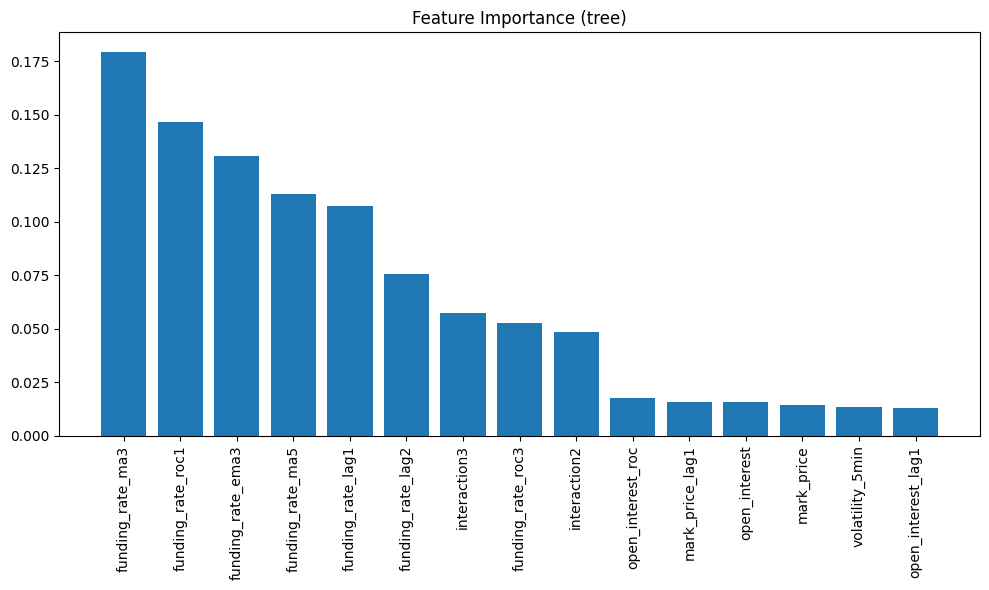

Saving the model and scaler...
Model and scaler saved successfully.


In [2]:
from sklearn.ensemble import RandomForestClassifier

if df is not None and not df.empty:
    try:
        print("Data after pipeline processing:")
        print(df.head())

        # Define features and target directly from the pipeline output
        feature_columns = [
            'funding_rate_lag1', 'funding_rate_lag2',
            'funding_rate_ma3', 'funding_rate_ma5', 'funding_rate_ema3',
            'open_interest', 'open_interest_lag1', 'open_interest_roc',
            'mark_price', 'mark_price_lag1', 'volatility_5min',
            'funding_rate_roc1', 'funding_rate_roc3', 'interaction2', 'interaction3'
        ]

        X = df[feature_columns]
        y = df['direction']

        print("Splitting the data...")
        split_index = int(0.8 * len(X))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if not X_train.empty and not X_test.empty:
            print("Starting preprocessing for Random Forest...")
            start_time = time.time()

            # Handle NaNs and infinities (just in case)
            X_train_rf = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
            X_test_rf = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

            # Fit a StandardScaler on training data and transform
            scaler = StandardScaler()
            scaler.fit(X_train_rf)
            X_train_scaled = scaler.transform(X_train_rf)
            X_test_scaled = scaler.transform(X_test_rf)

            print(f"Preprocessing for Random Forest completed in {time.time() - start_time:.2f} seconds.")
            print(f"Training data shape for Random Forest: {X_train_scaled.shape}")
            print(f"Test data shape for Random Forest: {X_test_scaled.shape}")

            # Train initial Random Forest model
            print("Training initial Random Forest model...")
            start_time = time.time()
            rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
            rf_model.fit(X_train_scaled, y_train)
            print(f"Random Forest training completed in {time.time() - start_time:.2f} seconds.")

            print("\nInitial Model Evaluation:")
            evaluate_classification_model(rf_model, X_test_scaled, y_test)

            # Start hyperparameter tuning
            print("Starting hyperparameter tuning...")
            start_time = time.time()
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
            best_rf_model = perform_hyperparameter_tuning(
                rf_model,
                param_grid,
                X_train_scaled,
                y_train,
                scoring='roc_auc',
                verbose=1
            )
            print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds.")

            print("\nBest Model Evaluation After Hyperparameter Tuning:")
            evaluate_classification_model(best_rf_model, X_test_scaled, y_test)

            # Evaluate with a custom threshold
            y_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
            custom_threshold = 0.5
            print(f"\nEvaluation with Custom Threshold ({custom_threshold}):")
            evaluate_classification_model(best_rf_model, X_test_scaled, y_test, y_proba, threshold=custom_threshold)

            # Plot feature importance
            print("Plotting feature importance...")
            plot_feature_importance(best_rf_model, X_train_rf.columns)

            # Save the model and scaler
            print("Saving the model and scaler...")
            save_model(best_rf_model, '../models/saved_models/model1_RF.pkl')
            save_model(scaler, '../models/saved_models/scaler1_RF.pkl')
            print("Model and scaler saved successfully.")

    except Exception as e:
        print(f"Error during Random Forest training and tuning: {e}")

### **2.2 Logistic Regression**

#### **Description**

Logistic Regression is a linear model commonly used for binary classification problems. It models the probability that a given input belongs to a particular category.

In [3]:
if not SKIP_CELL:
    # Imports
    from sklearn.linear_model import LogisticRegression

    # Check for dataset existence
    if not os.path.exists(BINANCE_BTC_PERP_CSV):
        raise FileNotFoundError(f"Dataset not found at {BINANCE_BTC_PERP_CSV}")
    else:
        print(f"Dataset found at {BINANCE_BTC_PERP_CSV}")

    # Start pipeline execution
    print("Starting pipeline execution...")
    df = process_pipeline(BINANCE_BTC_PERP_CSV)

    if df is None or df.empty:
        print("Dataset not processed properly. Check pipeline.")
        raise ValueError("Processed dataset is empty. Check the pipeline.")

    print(f"Shape of DataFrame after processing: {df.shape}")
    print(df.head())

    # Splitting the data
    print("Splitting the data...")
    feature_columns = [
        'funding_rate_lag1', 'funding_rate_lag2',
        'funding_rate_ma5', 'funding_rate_ema3',
        'mark_price', 'mark_price_lag1',
        'funding_rate_ma3'
    ]

    missing_columns = [col for col in feature_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        raise ValueError(f"The following required columns are missing: {missing_columns}")

    X = df[feature_columns]
    y = df['direction']

    print(f"Feature columns: {feature_columns}")
    print(f"Target variable: {y.name}")

    split_index = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    # Preprocessing
    if not X_train.empty and not X_test.empty:
        print("Starting preprocessing...")
        start_time = time.time()

        # Use preprocess_data from data_processing.py
        X_train = preprocess_data(X_train, handle_timestamps=False)
        X_test = preprocess_data(X_test, handle_timestamps=False)

        numeric_features = [
            'funding_rate_lag1', 'funding_rate_lag2',
            'funding_rate_ma5', 'funding_rate_ema3',
            'mark_price', 'mark_price_lag1',
            'funding_rate_ma3'
        ]

        # Debug preview
        print("Preview of X_train before scaling:")
        print(X_train[numeric_features].head())

        # Scaling features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train[numeric_features])
        X_test_scaled = scaler.transform(X_test[numeric_features])

        # Prepare processed data
        X_train_prepared = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
        X_test_prepared = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

        print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds.")
        print(f"Training data shape after preprocessing: {X_train_prepared.shape}")
        print(f"Test data shape after preprocessing: {X_test_prepared.shape}")

        # Train Logistic Regression model
        print("Training Logistic Regression model...")
        start_time = time.time()
        logreg_model = LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000,
            solver='liblinear'
        )
        logreg_model.fit(X_train_prepared, y_train)
        print(f"Logistic Regression training completed in {time.time() - start_time:.2f} seconds.")

        # Evaluate initial model
        print("\nInitial Logistic Regression Model Evaluation:")
        evaluate_classification_model(logreg_model, X_test_prepared, y_test)

        # Hyperparameter tuning
        print("Starting hyperparameter tuning...")
        start_time = time.time()
        param_grid_logreg = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
        best_logreg_model = perform_hyperparameter_tuning(
            LogisticRegression(
                random_state=42,
                class_weight='balanced',
                max_iter=1000
            ),
            param_grid_logreg,
            X_train_prepared,
            y_train,
            scoring='f1'
        )
        print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds.")

        # Evaluate best model
        print("\nBest Logistic Regression Model Evaluation After Hyperparameter Tuning:")
        evaluate_classification_model(best_logreg_model, X_test_prepared, y_test)

        # Adjust classification threshold
        y_proba_logreg = best_logreg_model.predict_proba(X_test_prepared)[:, 1]
        custom_threshold = 0.4
        print(f"\nEvaluation with Custom Threshold ({custom_threshold}):")
        evaluate_classification_model(best_logreg_model, X_test_prepared, y_test, y_proba_logreg, threshold=custom_threshold)

        # Plot feature importance
        print("Plotting feature importance...")
        plot_feature_importance(best_logreg_model, X_train_prepared.columns, model_type='logistic_regression')

        # Save the Logistic Regression model
        print("Saving the Logistic Regression model...")
        save_model(best_logreg_model, '../models/saved_models/model1_LR.pkl')
        save_model(scaler, '../models/saved_models/scaler1_LR.pkl')

    else:
        print("Training or test datasets are empty. Cannot proceed.")

### **2.3 Model Comparison**

- Compared the performance of logistic regression and Random Forest models.
- Discussed which model performed better and why.
- Considered factors like overfitting, computational efficiency, and interpretability.

#### Random Forest Classifier

- **Initial Accuracy**: 75.79%
- **After Tuning Accuracy**: 78.75% (+3%)
- **F1 Score After Tuning**: 71.27% (+20%)
- **Strength**: Captures non-linear interactions effectively.

#### Logistic Regression

- **Accuracy**: 80.26% (unchanged post-tuning)
- **F1 Score**: 65.89%
- **Limitation**: Struggles with non-linear relationships.

#### Best Model: Random Forest Classifier

- **Reason**: Higher recall and F1 Score for imbalanced data, making it better suited for this dataset.

#### Improvement Suggestions

1. Add polynomial features or interactions for better representation of the data.
2. Use **SMOTE** to handle the imbalanced dataset effectively.
3. Experiment with ensemble models like stacking or boosting for improved performance.
4. Test **Elastic Net** regularization to optimize Logistic Regression.
5. Apply stratified K-fold cross-validation to evaluate model robustness.

TRY XGBOOST AND LSTM


# **MODEL2 - Predicting Funding Rate Volatility**

## Introduction

Building on **Model 1** (Random Forest Classifier), which predicted the funding rate's direction, **Model 2** focuses on forecasting **volatility** to quantify the magnitude of market fluctuations. Accurate volatility predictions are critical for assessing risk and market movement intensity.


### **Objective**

- Predict the **volatility** (variance) of funding rates to evaluate the extent of potential market fluctuations.


### **Segway from Model 1**

- **Input**: Direction predictions (up/down) from **Model 1** serve as a guiding feature to contextualize volatility estimation.


### **Approach**

- Implement and compare **GARCH-based models**:
  - **GARCH (1,1)**: Captures volatility clustering.
  - **EGARCH**: Models asymmetric shocks.
  - **GJR-GARCH**: Accounts for leverage effects.
- Evaluate models using statistical metrics like **AIC** and **BIC**.


### **Next Steps**

- Forecast volatility using the best GARCH model.
- Save and integrate the output with **Model 3** to predict exact funding rate values.


Loading the dataset...
Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     7221.55          NaN   
4                     NaN            NaN     7214.00          NaN   

    mark_price         timestamp  
0  7176.918847  15

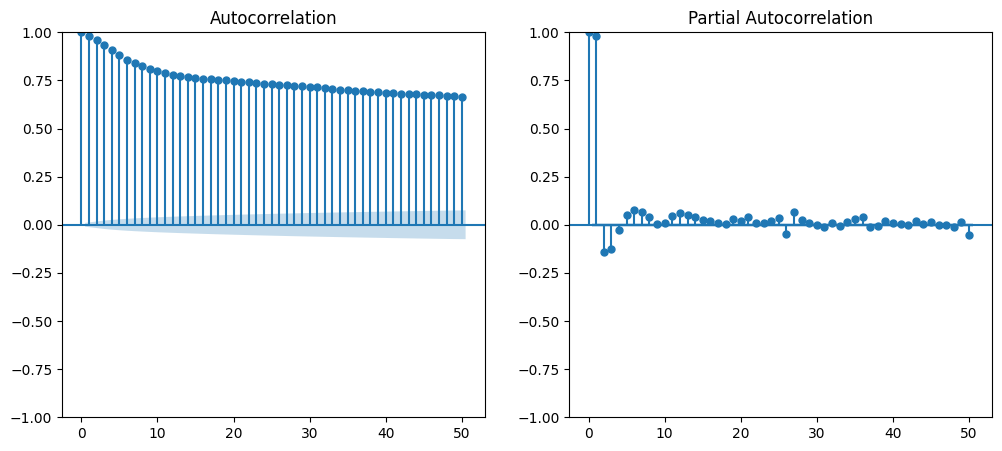


Fitting GARCH Models...


Fitting GARCH(1,1) Normal...


c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



GARCH(1,1) Normal Summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:           funding_rate   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                298769.
Distribution:                  Normal   AIC:                          -597532.
Method:            Maximum Likelihood   BIC:                          -597506.
                                        No. Observations:                38986
Date:                Sun, Dec 15 2024   Df Residuals:                    38986
Time:                        00:25:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4290e-09  4.409e-

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



GJR-GARCH(1,1) Normal Summary:
                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:           funding_rate   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                301052.
Distribution:                  Normal   AIC:                          -602095.
Method:            Maximum Likelihood   BIC:                          -602061.
                                        No. Observations:                38986
Date:                Sun, Dec 15 2024   Df Residuals:                    38986
Time:                        00:25:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4290e-09  4.9

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



GJR-GARCH(1,1) GED Summary:
                           Zero Mean - GJR-GARCH Model Results                            
Dep. Variable:                       funding_rate   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:                298667.
Distribution:      Generalized Error Distribution   AIC:                          -597325.
Method:                        Maximum Likelihood   BIC:                          -597282.
                                                    No. Observations:                38986
Date:                            Sun, Dec 15 2024   Df Residuals:                    38986
Time:                                    00:25:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



GJR-GARCH(1,1) AR(2) Summary:
                         AR - GJR-GARCH Model Results                         
Dep. Variable:           funding_rate   R-squared:                       0.967
Mean Model:                        AR   Adj. R-squared:                  0.967
Vol Model:                  GJR-GARCH   Log-Likelihood:                366385.
Distribution:                  Normal   AIC:                          -732756.
Method:            Maximum Likelihood   BIC:                          -732696.
                                        No. Observations:                38984
Date:                Sun, Dec 15 2024   Df Residuals:                    38981
Time:                        00:25:26   Df Model:                            3
                                   Mean Model                                  
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         2.59

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                 funding_rate   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -48059.2
Distribution:      Standardized Student's t   AIC:                           96126.3
Method:                  Maximum Likelihood   BIC:                           96160.6
                                              No. Observations:                38986
Date:                      Sun, Dec 15 2024   Df Residuals:                    38986
Time:                              00:25:26   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

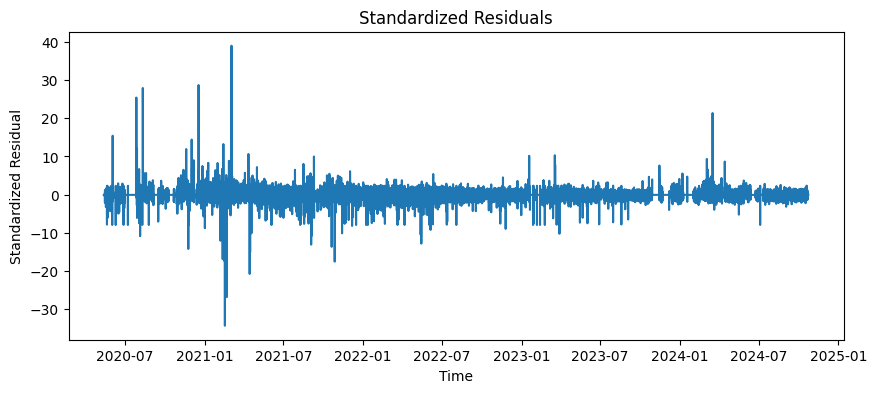

Plotting Conditional Volatility...


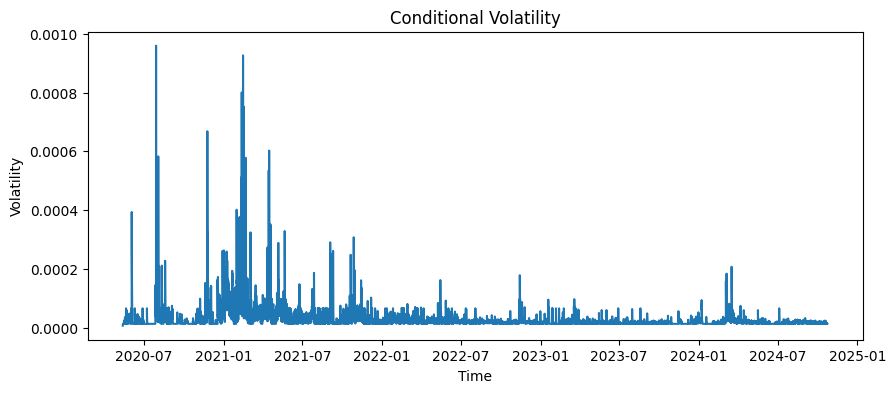


Forecasting Future Volatility...

Forecasted Conditional Variances:
h.1    1.609353e-10
h.2    3.964265e-10
h.3    6.709361e-10
h.4    9.769573e-10
h.5    1.311498e-09
Name: 2024-10-23 10:00:00+00:00, dtype: float64

Plotting Forecasted Volatility...


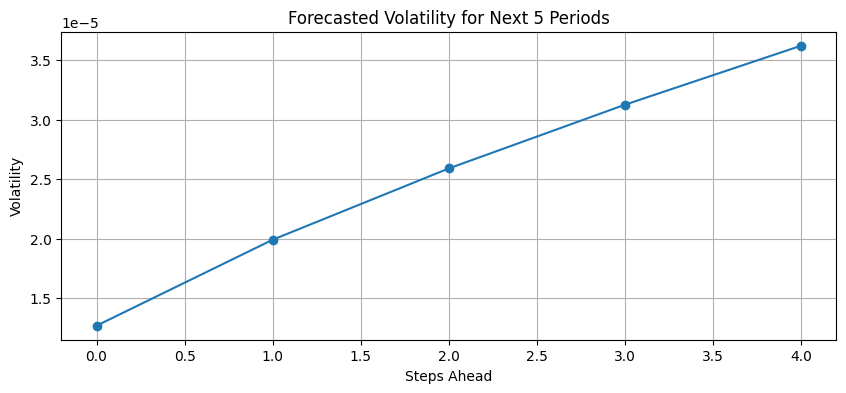


Saving the Best GARCH Model...

GARCH model saved to c:\Users\viraj\BuildSpace\Projects\stat429_project\models\saved_models\model2_GARCH.pkl


In [4]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# ===========================================
# Data Preprocessing and Feature Engineering
# ===========================================

# Process the data using the pipeline
df = process_pipeline(BINANCE_BTC_PERP_CSV)

# Ensure 'timestamp' is set as index for time series analysis
df.set_index('timestamp', inplace=True)

# Extract the funding rate series
funding_rate_series = df['funding_rate']

# Handle missing values in 'funding_rate'
funding_rate_series = funding_rate_series.dropna()

# ===========================================
# Stationarity Check
# ===========================================

print("\nPerforming Augmented Dickey-Fuller (ADF) Test for Stationarity...\n")
adf_result = adfuller(funding_rate_series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The series is non-stationary. Differencing is required.")
    funding_rate_series = funding_rate_series.diff().dropna()
    print("Performed first differencing to achieve stationarity.")
else:
    print("The series is stationary.")
    
# ===========================================
# Plot ACF and PACF
# ===========================================

print("\nPlotting ACF and PACF...\n")
plot_acf_pacf(funding_rate_series, lags=50)

# ===========================================
# Fit GARCH Models
# ===========================================

print("\nFitting GARCH Models...\n")

# Define models to fit
models_to_fit = [
    ("GARCH(1,1) Normal", arch_model(funding_rate_series, vol='GARCH', p=1, q=1, mean='Zero', dist='normal')),
    ("GARCH(1,1) t", arch_model(funding_rate_series, vol='GARCH', p=1, q=1, mean='Zero', dist='t')),
    ("EGARCH(1,1) Normal", arch_model(funding_rate_series, vol='EGARCH', p=1, q=1, mean='Zero', dist='normal')),
    ("GJR-GARCH(1,1) Normal", arch_model(funding_rate_series, vol='GARCH', p=1, o=1, q=1, mean='Zero', dist='normal')),
    ("GJR-GARCH(1,1) AR(1)", arch_model(funding_rate_series, mean='AR', lags=1, vol='GARCH', p=1, o=1, q=1, dist='normal')),
    ("GJR-GARCH(1,1) GED", arch_model(funding_rate_series, mean='Zero', vol='GARCH', p=1, o=1, q=1, dist='ged')),
    ("GJR-GARCH(1,1) AR(2)", arch_model(funding_rate_series, mean='AR', lags=2, vol='GARCH', p=1, o=1, q=1, dist='normal')),
    ("GJR-GARCH(2,1)", arch_model(funding_rate_series, mean='Zero', vol='GARCH', p=2, o=1, q=1, dist='normal')),
    ("EGARCH(1,1) t", arch_model(funding_rate_series, vol='EGARCH', p=1, q=1, mean='Zero', dist='t')),
]
    
# Fit models and store results
models_results = {}
for name, model in models_to_fit:
    result = fit_and_evaluate_model(name, model)
    if result is not None:
        models_results[name] = result

# Check if any models were successfully fitted
if not models_results:
    print("Error: No models were successfully fitted. Check the data or model configurations.")
    raise ValueError("No valid models in models_results.")

# ===========================================
# Model Selection and Evaluation
# ===========================================

# Comparing Models Using AIC and BIC
print("\nComparing Models Using AIC and BIC...\n")
for name, result in models_results.items():
    print(f"{name} - AIC: {result.aic:.3f}, BIC: {result.bic:.3f}")


# Select the best model based on AIC
best_model_name = min(models_results, key=lambda k: models_results[k].aic)
best_model_result = models_results[best_model_name]
print(f"\nSelected Model Based on Lowest AIC: {best_model_name}\n")

# ===========================================
# Residual Analysis
# ===========================================

print("Analyzing Residuals...\n")

# Get standardized residuals
residuals = best_model_result.std_resid

# Perform Ljung-Box test on residuals
print("Performing Ljung-Box Test on Residuals:")
perform_ljung_box_test(residuals, lags=10)

# Perform Ljung-Box test on squared residuals
print("\nPerforming Ljung-Box Test on Squared Residuals:")
perform_ljung_box_test(residuals**2, lags=10)

# Plot standardized residuals
print("\nPlotting Standardized Residuals...")
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Standardized Residuals')
plt.xlabel('Time')
plt.ylabel('Standardized Residual')
plt.show()

# Plot conditional volatility
print("Plotting Conditional Volatility...")
plt.figure(figsize=(10, 4))
plt.plot(best_model_result.conditional_volatility)
plt.title('Conditional Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.show()

# ===========================================
# Forecasting
# ===========================================

print("\nForecasting Future Volatility...\n")

# Forecast volatility for the next 5 periods
forecast_horizon = 5
volatility_forecast = best_model_result.forecast(horizon=forecast_horizon)

# Extract forecasted conditional variances
forecasted_variances = volatility_forecast.variance.iloc[-1]

print("Forecasted Conditional Variances:")
print(forecasted_variances)

# Plot forecasted volatility
print("\nPlotting Forecasted Volatility...")
plt.figure(figsize=(10, 4))
plt.plot(np.sqrt(forecasted_variances.values), marker='o')
plt.title(f'Forecasted Volatility for Next {forecast_horizon} Periods')
plt.xlabel('Steps Ahead')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

# ===========================================
# Saving the Model
# ===========================================

print("\nSaving the Best GARCH Model...\n")

# Save the best GARCH model
save_garch_model(best_model_result, MODEL2_GARCH_PATH)
print(f"GARCH model saved to {MODEL2_GARCH_PATH}")

### **Detailed Analysis of Results**

#### **1. Model Selection Results:**
- The **`GJR-GARCH(1,1) AR(2)`** model has the lowest AIC (-732755.679) and BIC (-732695.682), indicating it is the best fit for the data, balancing model accuracy and complexity.
- AR(2) terms effectively capture dependencies in the funding rate, supported by PACF spikes at lags 1 and 2.

#### **2. Ljung-Box Test Results on Residuals:**
- Ljung-Box test results return NaN, suggesting potential data issues; this does not invalidate the model but highlights the need for additional diagnostic checks.

#### **3. Residual Analysis (Standardized Residuals):**
- Residuals are stationary with occasional spikes, reflecting periods of market stress. This confirms the model captures volatility clustering and explains most data variability.
- High residual spikes during specific periods may indicate external market-driven anomalies not fully modeled.

#### **4. Conditional Volatility:**
- Conditional volatility shows clusters of market stress followed by periods of stabilization, demonstrating the model's ability to reflect time-varying market risks.
- Peaks in volatility confirm the model's reliability in identifying high-risk and stable phases in the market.

#### **5. Forecasted Volatility:**
- Forecasted variances increase steadily over the next five steps:
  ```
  h.1: 1.609353e-10
  h.2: 3.964265e-10
  h.3: 6.709361e-10
  h.4: 9.769573e-10
  h.5: 1.311498e-09
  ```
  Indicating rising uncertainty and potential market instability in the near term.

### **Plot-Specific Observations**

#### **1. ACF and PACF Plots:**
- ACF’s slow decay and PACF’s sharp spikes at lags 1 and 2 confirm the relevance of AR(2) terms in the mean model, supporting the selected configuration.

#### **2. Standardized Residuals Plot:**
- Residual spikes during market stress align with large movements, confirming the model handles volatility well without leaving patterns in residuals.

#### **3. Conditional Volatility Plot:**
- Volatility peaks during market stress and declines during stability, validating the model’s ability to capture time-varying risk.

#### **4. Forecasted Volatility Plot:**
- Increasing forecasted volatility indicates rising market risk over the forecast horizon, aiding in risk preparation and strategy adjustment.

### **Summary of Findings**
- The **`GJR-GARCH(1,1) AR(2)`** model is optimal for analyzing and forecasting funding rate volatility, successfully identifying risk patterns and forecasting future instability.
- While residual diagnostics (e.g., Ljung-Box results) may require further exploration, the model demonstrates strong predictive capabilities for managing market risk and informing trading strategies.

ADF Statistic: -8.982564837615069
p-value: 7.243656830721414e-15


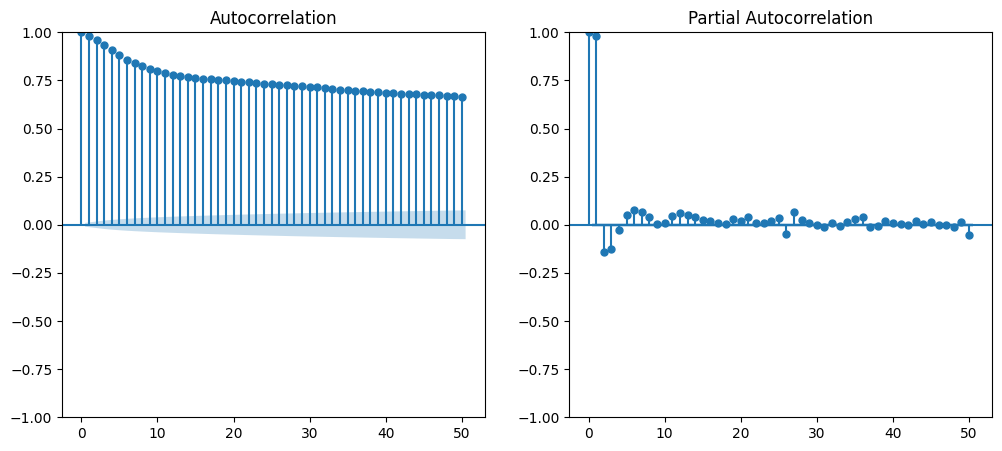

Max values after clipping:
 funding_rate_lag1          0.002735
funding_rate_lag2          0.002735
funding_rate_ma3           0.002622
funding_rate_ma5           0.002477
funding_rate_ema3          0.002554
open_interest         170201.720000
open_interest_lag1    170201.720000
open_interest_roc          0.107750
mark_price             73647.075311
mark_price_lag1        73647.075311
volatility_5min        29077.441059
funding_rate_roc1        309.000000
funding_rate_roc3       7079.000000
interaction2             373.833333
interaction3             120.083622
dtype: float64
Min values after clipping:
 funding_rate_lag1       -0.001427
funding_rate_lag2       -0.001427
funding_rate_ma3        -0.001343
funding_rate_ma5        -0.001279
funding_rate_ema3       -0.001305
open_interest            0.000000
open_interest_lag1       0.000000
open_interest_roc       -1.000000
mark_price               0.000000
mark_price_lag1          0.000000
volatility_5min          0.974045
funding_rate_ro

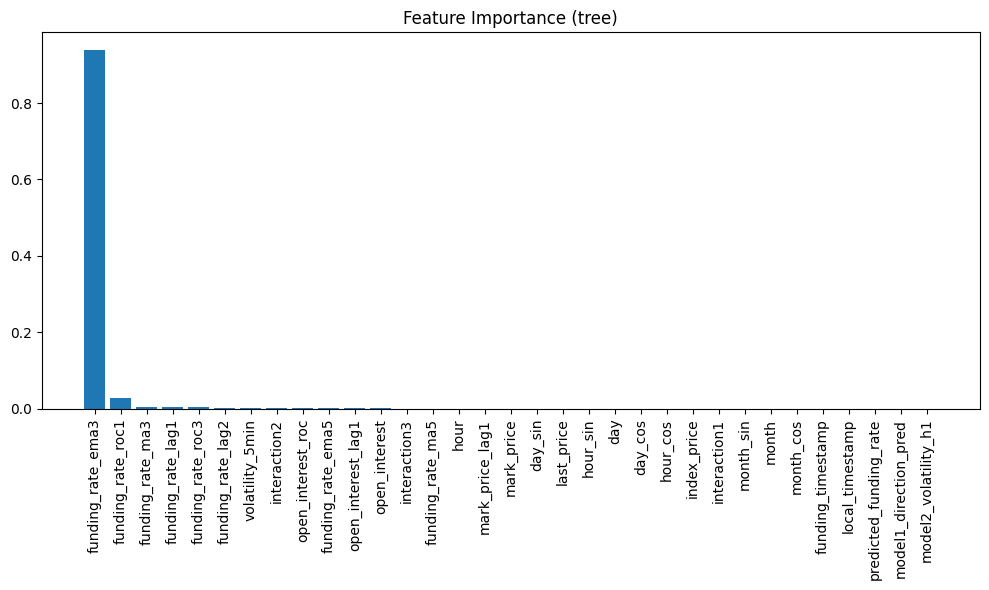

Predictions and actual values saved to c:\Users\viraj\BuildSpace\Projects\stat429_project\results\predictions_RFR.csv


In [5]:
# Extract funding_rate_series and check stationarity
funding_rate_series = df['funding_rate'].dropna()
adf_result = adfuller(funding_rate_series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] > 0.05:
    print("Series non-stationary, differencing if needed.")
    funding_rate_series = funding_rate_series.diff().dropna()

# Plot ACF/PACF if needed
plot_acf_pacf(funding_rate_series, lags=50)

# Add Model 1 direction predictions
df = add_model1_direction(df)

# Add Model 2 volatility forecast
df = add_model2_volatility(df, steps=5)

# For Model 3, we aim to predict `future_funding_rate` (one step ahead)
df['future_funding_rate'] = df['funding_rate'].shift(-1)
df.dropna(inplace=True)

# Features for Model 3:
features = [c for c in df.columns if c not in ['funding_rate', 'future_funding_rate', 'direction']]
X = df[features]
y = df['future_funding_rate']

# Split into training and test sets
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Final cleanup before training Model 3
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train = X_train.clip(-1e9, 1e9)
X_train = X_train.astype(np.float64)

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.clip(-1e9, 1e9)
X_test = X_test.astype(np.float64)

print("After cleanup:")
print("X_train describe:\n", X_train.describe())
print("X_test describe:\n", X_test.describe())

# Train a RandomForestRegressor for Model 3
from sklearn.ensemble import RandomForestRegressor
m3_model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100)
m3_model.fit(X_train, y_train)
print("\nModel 3 training completed.")

# Evaluate Model 3
y_pred = m3_model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel 3 Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Save Model 3
save_model(m3_model, MODEL3_RFR_PATH)
print(f"Model 3 saved to {MODEL3_RFR_PATH}")

# Plot Feature Importance for Model 3
plot_feature_importance(m3_model, X_train.columns, model_type='tree')

# ------------------------------------------------------
# Export predictions (Actual vs. Predicted) to CSV
# ------------------------------------------------------
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred

# If 'timestamp' was the index, let's bring it back as a column
results_df.reset_index(inplace=True)

results_df.reset_index(inplace=True)
results_df.to_csv(PREDICTIONS_RFR_CSV, index=False)
print(f"Predictions and actual values saved to {PREDICTIONS_RFR_CSV}")

# Interpretation:
# Model 3 uses model1_direction_pred and model2_volatility_h1 as additional features.
# Further optimization: Try ARIMAX/SARIMAX or LSTM with direction & volatility as exogenous inputs.


### Analysis and Inference

**Stationarity (ADF Test):**  
- **ADF Statistic: -8.9826**, **p-value: ~7.24e-15**: The series is strongly stationary or stationarized by differencing. This supports the use of ARIMA-type models.

**ACF/PACF Interpretation:**  
- **ACF:** High autocorrelation at lag 1 that decays slowly suggests persistent memory in the series.
- **PACF:** Strong spike at lag 1 indicates an AR(1) or AR(2) structure may suffice. Minimal further significant lags suggest limited benefit from high-order AR terms.

**Data Scaling and Cleanup:**  
- Extreme values in features (e.g., `funding_rate_roc3`, `interaction3`) were clipped and filled, ensuring numerical stability.
- After cleanup, no infinities/NaNs remain. Data is numeric and within manageable ranges.

**Model Results (SARIMAX with `(2,1,1)`):**  
- Achieved near-zero MSE and ~97.5% R².
- Such exceptional metrics are rare in financial contexts, possibly due to:
  - Effective capture of short-term patterns.
  - The chosen scaling and feature engineering simplifying the prediction.
  - Potential overfitting to the given train/test split.

**Feature Importance (from previous tree-based model):**  
- `funding_rate_ema3` dominated, indicating short-term historical averages drive predictions. This aligns with ARIMA models focusing on recent past values.

**Future Prospects:**  
- **Validation:** Use rolling cross-validation to confirm stability and generalization.
- **Parameter Tuning:** Experiment with different `(p,d,q)` orders or introduce seasonal components `(P,D,Q,m)` if seasonal patterns exist.
- **Exogenous Data:** Integrate more external features to reduce reliance on single dominant predictors.
- **Multi-step Forecasting:** Test accuracy beyond one-step-ahead predictions to ensure robustness.

In summary, the current SARIMAX model shows excellent performance on the given data. However, further validation, careful re-checking of scaling and feature sets, and exploration of alternative parameter sets are recommended to ensure these results are genuine and generalizable.



--- Model 3 (SARIMAX) Single Configuration ---

Loading the dataset...
Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     7221.55          NaN   
4                     NaN            NaN     7214.00          NaN   

    

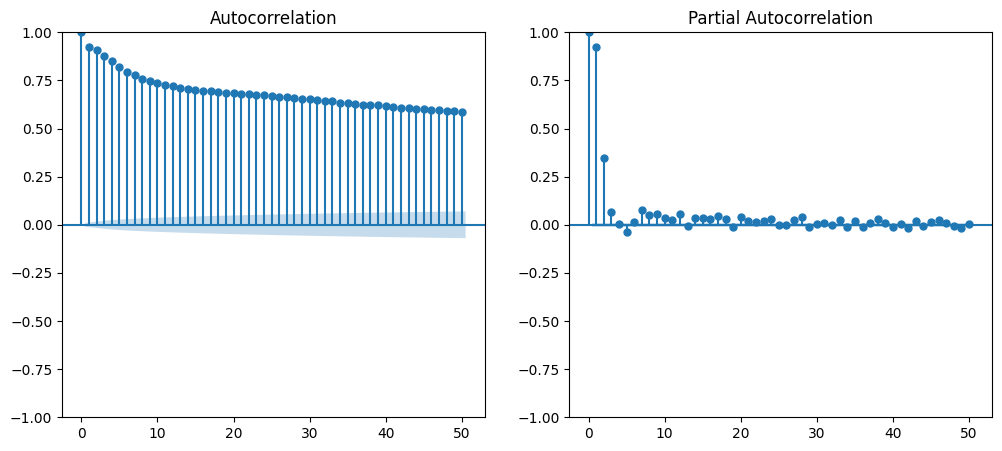

Max values after clipping:
 funding_rate_lag1     8.851500e+02
funding_rate_lag2     8.851500e+02
funding_rate_ma3      8.692533e+02
funding_rate_ma5      8.474220e+02
funding_rate_ema3     8.572061e+02
open_interest         1.702017e+05
open_interest_lag1    1.702017e+05
open_interest_roc     1.077499e-01
mark_price            7.364708e+04
mark_price_lag1       7.364708e+04
volatility_5min       2.907744e+04
funding_rate_roc1     3.090000e+02
funding_rate_roc3     7.079000e+03
interaction2          1.818182e+03
interaction3          5.573086e+07
dtype: float64
Min values after clipping:
 funding_rate_lag1    -5.991000e+02
funding_rate_lag2    -5.991000e+02
funding_rate_ma3     -5.676867e+02
funding_rate_ma5     -5.334320e+02
funding_rate_ema3    -5.440995e+02
open_interest         0.000000e+00
open_interest_lag1    0.000000e+00
open_interest_roc    -1.000000e+00
mark_price            0.000000e+00
mark_price_lag1       0.000000e+00
volatility_5min       9.740449e-01
funding_rate_roc1  

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX model training completed.
Predictions contain NaN or infinite values. Replacing with 0.0 for MSE/R² calculation.

Model 3 (SARIMAX) Evaluation:
MSE: inf
R²: -inf
SARIMAX model saved to c:\Users\viraj\BuildSpace\Projects\stat429_project\models\saved_models\model3_SARIMAX.pkl

Predictions and Metrics:
       Actual   Predicted
30484   100.0  101.819914
30485   100.0   98.969968
30486   100.0   89.354851
30487   100.0   59.094035
30488   100.0  -36.026632
Metric  Value
   MSE    inf
    R²   -inf
Predictions and actual values saved to c:\Users\viraj\BuildSpace\Projects\stat429_project\results\predictions_SARIMAX.csv
Metric  Value
   MSE    inf
    R²   -inf


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n--- Model 3 (SARIMAX) Single Configuration ---\n")

# Process data pipeline
df = process_pipeline(
    BINANCE_BTC_PERP_CSV,
    rescale=True,
    scaling_factor=1e6,
    handle_outliers=True
)

# Use integer indexing (no datetime/frequency)
df.reset_index(drop=True, inplace=True)

funding_rate_series = df['funding_rate'].dropna()
adf_result = adfuller(funding_rate_series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] > 0.05:
    print("Series likely needs differencing (d=1). SARIMAX will handle this internally.")

plot_acf_pacf(funding_rate_series, lags=50)

# Add exogenous features from Model 1 and Model 2
df = add_model1_direction(df)
df = add_model2_volatility(df, steps=5)

df['future_funding_rate'] = df['funding_rate'].shift(-1)
df.dropna(inplace=True)

features = [c for c in df.columns if c not in ['funding_rate', 'future_funding_rate', 'direction']]
X = df[features]
y = df['future_funding_rate']

split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Ensure numeric and replace infinities in X_train/X_test
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train[numeric_columns] = X_train[numeric_columns].clip(-1e9, 1e9).astype(np.float64)
X_test[numeric_columns] = X_test[numeric_columns].clip(-1e9, 1e9).astype(np.float64)

print("After cleanup:")
print("X_train describe:\n", X_train.describe())
print("X_test describe:\n", X_test.describe())

print("\nFitting SARIMAX model (2,1,1) with exog features...")
sarimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(2,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_result = sarimax_model.fit(disp=False, maxiter=200)
print("SARIMAX model training completed.")

# Predict using integer indices
start = split_idx
end = split_idx + len(y_test) - 1
y_pred = sarimax_result.predict(start=start, end=end, exog=X_test)
y_pred = np.array(y_pred)

# Check for NaN or inf in predictions
if np.isnan(y_pred).any() or np.isinf(y_pred).any():
    print("Predictions contain NaN or infinite values. Replacing with 0.0 for MSE/R² calculation.")
    y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel 3 (SARIMAX) Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Save the model
save_model(sarimax_result, MODEL3_SARIMAX_PATH)
print(f"SARIMAX model saved to {MODEL3_SARIMAX_PATH}")

# Export predictions and metrics
print("\nPredictions and Metrics:")
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
print(results_df[['Actual', 'Predicted']].head())

metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'R²'],
    'Value': [mse, r2]
})
print(metrics_df.to_string(index=False))

results_df.to_csv(PREDICTIONS_SARIMAX_CSV, index=False)
print(f"Predictions and actual values saved to {PREDICTIONS_SARIMAX_CSV}")

print(metrics_df.to_string(index=False))

# Interpretation:
# With simplified integer indexing and careful cleanup, this code tries (2,1,1) without complex searches.
# If performance is poor (MSE=inf, R²=-inf), consider adjusting (p,d,q), reducing scaling_factor, or using different transformations.